In [60]:
#import get to call a get request on the site
from requests import get

#get the 1st page of the chicago housing prices 
#get rid of posts without a pic using their filter
response = get('https://chicago.craigslist.org/search/chc/apa?hasPic=1&availabilityMode=0')

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 120 (elements/page)

<class 'bs4.element.ResultSet'>
120


In [61]:
#get first post
post_one = posts[0]

In [62]:
#price of 1st post
post_one_price = post_one.a.text
#remove comma from listing
#post_one_price = post_one.a.text.replace(',', '')
post_one_price.strip()

'$1,500'

In [63]:
#get the time of the post in datetime format
post_one_time = post_one.find('time', class_= 'result-date')
post_one_datetime = post_one_time['datetime']

In [64]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']

#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text

In [55]:
#execute multiple statements per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [65]:
#grabs the whole segment of housing details. We will need missing value handling in the loop as this kind of detail is not common in posts
#the text can be split, and we can use indexing to grab the elements we want. number of bedrooms is the first element.
#sqft is the third element
post_one_num_bedrooms = post_one.find('span', class_ = 'housing').text.split()[0]
post_one_num_bedrooms

post_one_sqft = post_one.find('span', class_ = 'housing')
post_one_sqft

post_one_sqft = post_one.find('span', class_ = 'housing').text.split()[2][:-3]
post_one_sqft
#post_one_sqft = post_one.find('span', class_ = 'housing').text.split()[2][:-3] #cleans the ft2 at the end

'3br'

<span class="housing">
                    3br -
                    1600ft<sup>2</sup> -
                </span>

'1600'

In [66]:
#the neighborhood is grabbed by finding the span class 'result-hood' and pulling the text element from there

post_one_hood = posts[0].find('span', class_='result-hood').text

AttributeError: 'NoneType' object has no attribute 'text'

In [70]:
#build out the loop
from time import sleep
import re
##this will allow us to scrape without getting blocked by craigslist
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:
    
    #get request
    response = get("https://chicago.craigslist.org/search/chc/apa?" 
                   + "s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
                   + "&hasPic=1"
                   + "&availabilityMode=0")

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, the comma 
            #and turns it into an int
            post_price = int(post.a.text.strip().replace("$", "").replace(",",""))
            #post_price = int(post.a.text.strip().replace(',', '')
            post_prices.append(post_price)
                        
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!
Page 22 scraped successfully!
Page 23 scraped successfully!
Page 24 scraped successfully!
Page 25 scraped successfully!
Page 26 scraped successfully!


Scrape complete!


In [71]:
import pandas as pd

ch_apts = pd.DataFrame({'Posted': post_timing,
                       'Neighborhood': post_hoods,
                       'Post_Title': post_title_texts,
                       'Num_Bedrooms': bedroom_counts,
                        'Sqft': sqfts,
                        'URL': post_links,
                       'Price': post_prices})
print(ch_apts.info())
ch_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2990 entries, 0 to 2989
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Posted        2990 non-null   object 
 1   Neighborhood  2990 non-null   object 
 2   Post_Title    2990 non-null   object 
 3   Num_Bedrooms  2106 non-null   object 
 4   Sqft          936 non-null    float64
 5   URL           2990 non-null   object 
 6   Price         2990 non-null   int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 163.6+ KB
None


,Posted,Neighborhood,Post_Title,Num_Bedrooms,Sqft,URL,Price
0,2020-12-02 12:56,(1834 W. Byron St. Chicago IL.),Awesome 1 Bedroom Loft on quaint Byron street!,1,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1100
1,2020-12-02 12:56,(Chicago),Roscoe Village - Large 1 Bed / 1 Bath / Den,1,1000.0,https://chicago.craigslist.org/chc/apa/d/chica...,1775
2,2020-12-02 12:52,(Kenwood/Hyde Park),"4746 S Greenwood Ave, Unit 3E",2,860.0,https://chicago.craigslist.org/chc/apa/d/chica...,1595
3,2020-12-02 12:47,(Logan Square),Logan Square 1 Bed Close 2 SQ! HWF|Cats Ok|1 M...,1,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1095
4,2020-12-02 12:46,(logan square),Updated Logan Square 3 Bed w/HWF|DW|Pets Ok|De...,3,1034.0,https://chicago.craigslist.org/chc/apa/d/chica...,1695
5,2020-12-02 12:44,(logan square),Logan Square 2 Bed w/HWF|Balcony|Pets Ok|One M...,2,940.0,https://chicago.craigslist.org/chc/apa/d/chica...,1495
6,2020-12-02 12:44,(1061 W. Rosemont),EDGEWATER! LOYOLA 1 BEDROOM ALL UTILITIES INCL...,1,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,975
7,2020-12-02 12:42,(Logan Square),HUGE Logan 1 Bed w/HWF|Dining Room|Pets Ok|1 M...,1,910.0,https://chicago.craigslist.org/chc/apa/d/chica...,1495
8,2020-12-02 12:42,(1061 W. Rosemont),EDGEWATER! LOYOLA STUDIO ALL UTILITIES INCLUDE...,NaN,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,675
9,2020-12-02 12:40,(logan square),Big Pet Friendly Logan 3 Bed w/EZ Parking|HWF|...,3,1200.0,https://chicago.craigslist.org/chc/apa/d/chica...,1595


In [0]:
########################DATA CLEANING


In [83]:
#Deleting duplicate postings bc people spam Craigslist with fake postings
# the duplicate postings are most likely spam
#Displays uniqe posts
ch_apts = ch_apts.drop_duplicates(subset='URL')
len(ch_apts.drop_duplicates(subset='URL'))

#converts the # of bedrooms to a float (since np.nan is a float too)
ch_apts['Num_Bedrooms'] = ch_apts['Num_Bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to work with it
from datetime import datetime
ch_apts['Posted'] = pd.to_datetime(ch_apts['Posted'])

#Checking neighborhoods that there are with ch_apts['neighborhood'].unique()
#Seeing that allowed me to know what I needed to deal with in terms of cleaning those

#remove the parenthesis from the left and right of the neighborhoods
ch_apts['Neighborhood'] = ch_apts['Neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))

ch_apts['Neighborhood'] = ch_apts['Neighborhood'].apply(lambda x: re.sub(r'[()]+', '', x))

#titlecase them
ch_apts['Neighborhood'] = ch_apts['Neighborhood'].str.title()

#just take the first name of the neighborhood list, splitting on the '/' delimiter
ch_apts['Neighborhood'] = ch_apts['Neighborhood'].apply(lambda x: x.split('/')[0])

#fix one-offs that
########################
#####################

#UPDATE
###################
########################
#remove whitespaces
ch_apts['Neighborhood'] = ch_apts['Neighborhood'].apply(lambda x: x.strip())

115

In [84]:
### EXPLORATORY DATA ANALYSIS
#Checking first record
ch_apts.head(1)

,Posted,Neighborhood,Post_Title,Num_Bedrooms,Sqft,URL,Price
0,2020-12-02 12:56:00,1834 W. Byron St. Chicago Il.,Awesome 1 Bedroom Loft on quaint Byron street!,1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1100


In [120]:
#Checking unique neighborhood names
ch_apts.Neighborhood.unique()

#removing listings that have addresses as listings
ch_apts = ch_apts[(ch_apts.Neighborhood != '1834 W. Byron St. Chicago Il.')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '151 N Michigan Ave')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '1061 W. Rosemont')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '2837 N Natoma #302')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '730 N Milwaukee Ave')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '3144 W 39Th Pl')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '1550 S Hamlin  North Lawndale')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '8901 S Loomis - Brainerd Senior Center')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '737 E 69Th')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '737 E 69Th')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '3144 W 39Th Pl, Chicago Il.')]






#(ch_apts.Neighborhood != 10)]

ch_apts.Neighborhood.unique()


array(['Roscoe Village', 'Kenwood', 'Logan Square',
       'Lincoln Park, Chicago', 'South Loop', 'Lincoln Square',
       'Wicker Park', 'Chicago', 'River North', 'South Shore',
       '3144 W 39Th Pl, Chicago Il.', 'West Town', 'Grand Crossing',
       'Portage Park', 'Washington Park', 'Lakeview', 'West Loop',
       'Albany Park', 'Adams Near Wells', 'Ravenswood',
       'Gold Coast - Lincoln Park - Old Town', 'Bucktown', 'Edgewater',
       'Rogers Park', 'Streeterville', 'Chicago - Uptown', 'Uptown',
       'Avondale', 'Lake Shore Dr-Gold Coast', 'Auburn Gresham',
       'Downtown South Loop', 'Wrigleyville', 'East Rogers Park',
       'Andersonville', 'Pilsen', 'West Wicker Park', 'Lincoln Park',
       'Hyde Park'], dtype=object)

array(['Roscoe Village', 'Kenwood', 'Logan Square',
       'Lincoln Park, Chicago', 'South Loop', 'Lincoln Square',
       'Wicker Park', 'Chicago', 'River North', 'South Shore',
       'West Town', 'Grand Crossing', 'Portage Park', 'Washington Park',
       'Lakeview', 'West Loop', 'Albany Park', 'Adams Near Wells',
       'Ravenswood', 'Gold Coast - Lincoln Park - Old Town', 'Bucktown',
       'Edgewater', 'Rogers Park', 'Streeterville', 'Chicago - Uptown',
       'Uptown', 'Avondale', 'Lake Shore Dr-Gold Coast', 'Auburn Gresham',
       'Downtown South Loop', 'Wrigleyville', 'East Rogers Park',
       'Andersonville', 'Pilsen', 'West Wicker Park', 'Lincoln Park',
       'Hyde Park'], dtype=object)

In [121]:
#Correcting neighborhood names
for Post_Title in ch_apts:
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Andersonville'), 'Neighborhood'] = 'Andersonville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('andersonville'), 'Neighborhood'] = 'Andersonville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Archer Heights'), 'Neighborhood'] = 'Archer Heights'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('archer Heights'), 'Neighborhood'] = 'Archer Heights'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Ashburn'), 'Neighborhood'] = 'Ashburn'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('ashburn'), 'Neighborhood'] = 'Ashburn'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Austin'), 'Neighborhood'] = 'Austin'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('austin'), 'Neighborhood'] = 'Austin'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('avon'), 'Neighborhood'] = 'Avondale'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Avon'), 'Neighborhood'] = 'Avondale'  
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Albany'), 'Neighborhood'] = 'Albany Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('albany'), 'Neighborhood'] = 'Albany Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Beverly'), 'Neighborhood'] = 'Beverly'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('beverly'), 'Neighborhood'] = 'Beverly'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('buck'), 'Neighborhood'] = 'Bucktown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Buck'), 'Neighborhood'] = 'Bucktown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Boys'), 'Neighborhood'] = 'Boystown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('boys'), 'Neighborhood'] = 'Boystown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('China'), 'Neighborhood'] = 'Chinatown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('china'), 'Neighborhood'] = 'Chinatown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Depaul'), 'Neighborhood'] = 'Depaul'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('depaul'), 'Neighborhood'] = 'Depaul'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Edison'), 'Neighborhood'] = 'Edison Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('edison'), 'Neighborhood'] = 'Edison Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Edgewater'), 'Neighborhood'] = 'Edgewater'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('edgewater'), 'Neighborhood'] = 'Edgewater'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Englewood'), 'Neighborhood'] = 'Englewood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('englewood'), 'Neighborhood'] = 'Englewood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Galewood'), 'Neighborhood'] = 'Galewood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('galewood'), 'Neighborhood'] = 'Galewood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Garfield Park'), 'Neighborhood'] = 'Garfield Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('garfield Park'), 'Neighborhood'] = 'Garfield Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Gold Coast'), 'Neighborhood'] = 'Gold Coast'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('gold'), 'Neighborhood'] = 'Gold Coast'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Gresham'), 'Neighborhood'] = 'Gresham'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('gresham'), 'Neighborhood'] = 'Gresham'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Humb'), 'Neighborhood'] = 'Humboldt Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('humb'), 'Neighborhood'] = 'Humboldt Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Hyde'), 'Neighborhood'] = 'Hyde Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('hyde'), 'Neighborhood'] = 'Hyde Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Jefferson'), 'Neighborhood'] = 'Jefferson Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('jefferson'), 'Neighborhood'] = 'Jefferson Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Kenwood'), 'Neighborhood'] = 'Kenwood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('kenwood'), 'Neighborhood'] = 'Kenwood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Lakeview'), 'Neighborhood'] = 'Lakeview'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('lakeview'), 'Neighborhood'] = 'Lakeview'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Little Village'), 'Neighborhood'] = 'Little Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Little village'), 'Neighborhood'] = 'Little Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('little village'), 'Neighborhood'] = 'Little Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('lil village'), 'Neighborhood'] = 'Little Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Lil village'), 'Neighborhood'] = 'Little Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Lincoln Park'), 'Neighborhood'] = 'Lincoln Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('lincoln park'), 'Neighborhood'] = 'Lincoln Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Lincoln Square'), 'Neighborhood'] = 'Lincoln Square'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('lincoln square'), 'Neighborhood'] = 'Lincoln Square'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Logan'), 'Neighborhood'] = 'Logan Square'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('logan'), 'Neighborhood'] = 'Logan Square'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Marquette Park'), 'Neighborhood'] = 'Marquette Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('marquette park'), 'Neighborhood'] = 'Marquette Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Midway'), 'Neighborhood'] = 'Midway'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('midway'), 'Neighborhood'] = 'Midway'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Mount Greenwood'), 'Neighborhood'] = 'Mount Greenwood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('mount greenwood'), 'Neighborhood'] = 'Mount Greenwood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Norwood'), 'Neighborhood'] = 'Norwood Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('norwood'), 'Neighborhood'] = 'Norwood Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Irving'), 'Neighborhood'] = 'Irving Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('irving'), 'Neighborhood'] = 'Irving Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Old Town'), 'Neighborhood'] = 'Old Town'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('old town'), 'Neighborhood'] = 'Old Town'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Pilsen'), 'Neighborhood'] = 'Pilsen'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('pilsen'), 'Neighborhood'] = 'Pilsen'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Portage'), 'Neighborhood'] = 'Portage Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('portage'), 'Neighborhood'] = 'Portage Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Pullman'), 'Neighborhood'] = 'Pullman'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('pullman'), 'Neighborhood'] = 'Pullman'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Ravens'), 'Neighborhood'] = 'Ravenswood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('ravens'), 'Neighborhood'] = 'Ravenswood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('River North'), 'Neighborhood'] = 'River North'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('river north'), 'Neighborhood'] = 'River North'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('River West'), 'Neighborhood'] = 'River West'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('river west'), 'Neighborhood'] = 'River West'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Rogers'), 'Neighborhood'] = 'Rogers Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('rogers'), 'Neighborhood'] = 'Rogers Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('rodgers'), 'Neighborhood'] = 'Rogers Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Roscoe Village'), 'Neighborhood'] = 'Roscoe Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('roscoe village'), 'Neighborhood'] = 'Roscoe Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Sauganash'), 'Neighborhood'] = 'Sauganash'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('sauganash'), 'Neighborhood'] = 'Sauganash'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('South Loop'), 'Neighborhood'] = 'South Loop'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('south loop'), 'Neighborhood'] = 'South Loop'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('South Shore'), 'Neighborhood'] = 'South Shore'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('south shore'), 'Neighborhood'] = 'South Shore'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Streeter'), 'Neighborhood'] = 'Streeterville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('streeter'), 'Neighborhood'] = 'Streeterville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Uptown'), 'Neighborhood'] = 'Uptown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('uptown'), 'Neighborhood'] = 'Uptown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('West Loop'), 'Neighborhood'] = 'West Loop'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('west loop'), 'Neighborhood'] = 'West Loop'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('West Town'), 'Neighborhood'] = 'West Town'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('west town'), 'Neighborhood'] = 'West Town'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Wicker'), 'Neighborhood'] = 'Wicker Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('wicker'), 'Neighborhood'] = 'Wicker Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Wrigleyville'), 'Neighborhood'] = 'Wrigleyville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('wrigleyville'), 'Neighborhood'] = 'Wrigleyville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('wrigley'), 'Neighborhood'] = 'Wrigleyville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Ukrainian Village'), 'Neighborhood'] = 'Ukrainian Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('ukrainian village'), 'Neighborhood'] = 'Ukrainian Village'

ch_apts

,Posted,Neighborhood,Post_Title,Num_Bedrooms,Sqft,URL,Price
1,2020-12-02 12:56:00,Roscoe Village,Roscoe Village - Large 1 Bed / 1 Bath / Den,1.0,1000.0,https://chicago.craigslist.org/chc/apa/d/chica...,1775
2,2020-12-02 12:52:00,Kenwood,"4746 S Greenwood Ave, Unit 3E",2.0,860.0,https://chicago.craigslist.org/chc/apa/d/chica...,1595
3,2020-12-02 12:47:00,Logan Square,Logan Square 1 Bed Close 2 SQ! HWF|Cats Ok|1 M...,1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1095
4,2020-12-02 12:46:00,Logan Square,Updated Logan Square 3 Bed w/HWF|DW|Pets Ok|De...,3.0,1034.0,https://chicago.craigslist.org/chc/apa/d/chica...,1695
5,2020-12-02 12:44:00,Logan Square,Logan Square 2 Bed w/HWF|Balcony|Pets Ok|One M...,2.0,940.0,https://chicago.craigslist.org/chc/apa/d/chica...,1495
...,...,...,...,...,...,...,...
110,2020-12-02 08:27:00,Rogers Park,"Heat, water and gas included! Walk to Red Line...",1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,925
111,2020-12-02 08:26:00,Lincoln Park,Amazing 1 Bed in Lincoln Park-bldg has 24hr do...,1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1400
112,2020-12-02 08:26:00,Hyde Park,1000 sq ft Condominium Studio For Rent!!,1.0,1000.0,https://chicago.craigslist.org/chc/apa/d/chica...,1000
113,2020-12-02 08:25:00,Lincoln Park,Studio in Lincoln Park w spacious floor plans ...,NaN,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1100


In [122]:
ch_apts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 1 to 114
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Posted        101 non-null    datetime64[ns]
 1   Neighborhood  101 non-null    object        
 2   Post_Title    101 non-null    object        
 3   Num_Bedrooms  71 non-null     float64       
 4   Sqft          33 non-null     float64       
 5   URL           101 non-null    object        
 6   Price         101 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.3+ KB


In [123]:
import pandas as pd, numpy as np

#get current directory
%pwd

#export dataframe to csv file
ch_apts.to_csv(r'C:\\Users\\chris\\2020\Craigslist-Data.csv')

'C:\\Users\\chris\\2020'

In [124]:
#use created file
chicago_apts = pd.read_csv("Craigslist-Data.csv")

chicago_apts.info()
chicago_apts.shape
chicago_apts.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    101 non-null    int64  
 1   Posted        101 non-null    object 
 2   Neighborhood  101 non-null    object 
 3   Post_Title    101 non-null    object 
 4   Num_Bedrooms  71 non-null     float64
 5   Sqft          33 non-null     float64
 6   URL           101 non-null    object 
 7   Price         101 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 6.4+ KB


(101, 8)

Index(['Unnamed: 0', 'Posted', 'Neighborhood', 'Post_Title', 'Num_Bedrooms',
       'Sqft', 'URL', 'Price'],
      dtype='object')

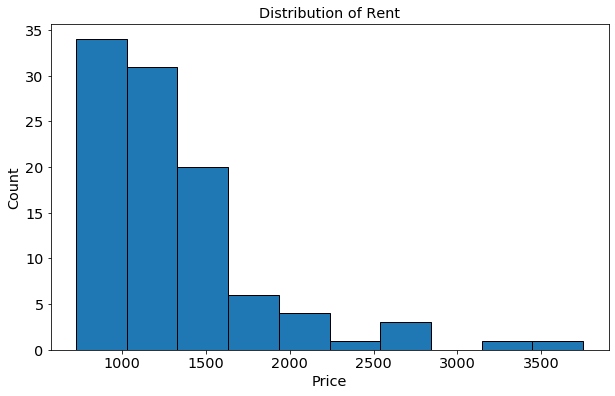

In [126]:
#start to look at the distributions
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.hist(chicago_apts['Price'], edgecolor='black');
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of Rent");

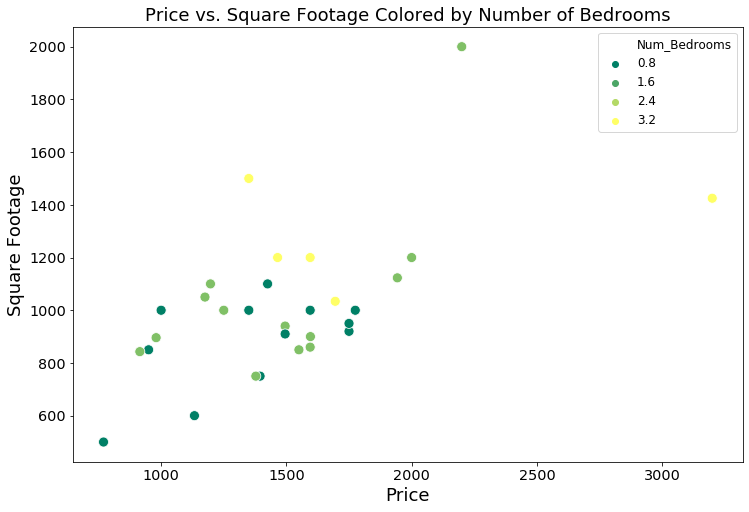

In [168]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Price', y='Sqft', hue='Num_Bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=100, data=ch_apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);

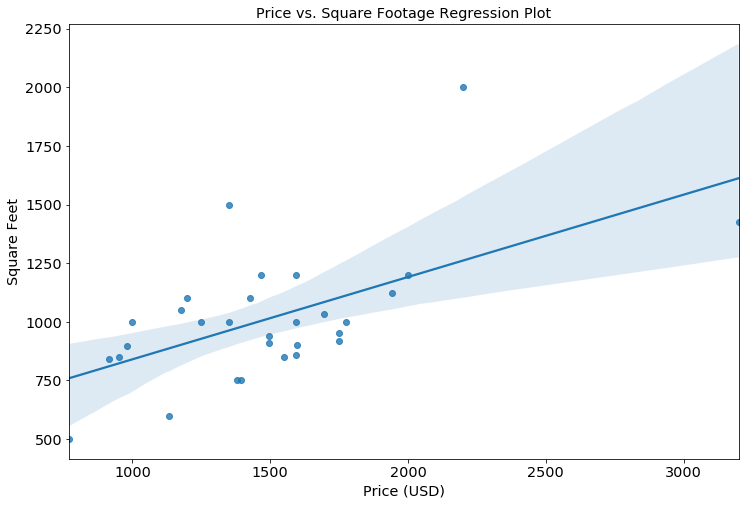

In [128]:
plt.figure(figsize=(12, 8))
sns.regplot(x='Price', y='Sqft', data=ch_apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price (USD)");
plt.ylabel("Square Feet");

In [129]:
#correlations of # of bedrooms, sqft and price
ch_apts.corr()

,Num_Bedrooms,Sqft,Price
Num_Bedrooms,1.000000,0.490698,0.337763
Sqft,0.490698,1.000000,0.659698
Price,0.337763,0.659698,1.000000


In [130]:
#group by neighborhood
ch_apts.groupby('Neighborhood').mean()

,Num_Bedrooms,Sqft,Price
Neighborhood,,,
Adams Near Wells,1.000000,NaN,1245.000000
Albany Park,1.666667,NaN,1300.000000
Andersonville,2.000000,900.0,1596.000000
Auburn Gresham,2.000000,843.0,915.000000
Avondale,2.000000,NaN,1395.000000
Bucktown,2.000000,1000.0,1250.000000
Chicago,1.800000,950.0,1042.500000
Chicago - Uptown,1.000000,NaN,950.000000
Downtown South Loop,2.000000,850.0,1550.000000


In [131]:
#sort price to find cheapest
ch_apts.groupby('Neighborhood').mean()['Price'].sort_values()

Neighborhood
South Shore                              770.000000
Edgewater                                857.600000
Auburn Gresham                           915.000000
Chicago - Uptown                         950.000000
Grand Crossing                           980.000000
Portage Park                            1000.000000
Hyde Park                               1000.000000
Uptown                                  1041.111111
Chicago                                 1042.500000
Rogers Park                             1078.750000
Pilsen                                  1100.000000
East Rogers Park                        1185.000000
Lincoln Square                          1185.000000
West Loop                               1221.761905
Adams Near Wells                        1245.000000
Bucktown                                1250.000000
Lincoln Park                            1250.000000
Logan Square                            1267.000000
Albany Park                             1300.000000

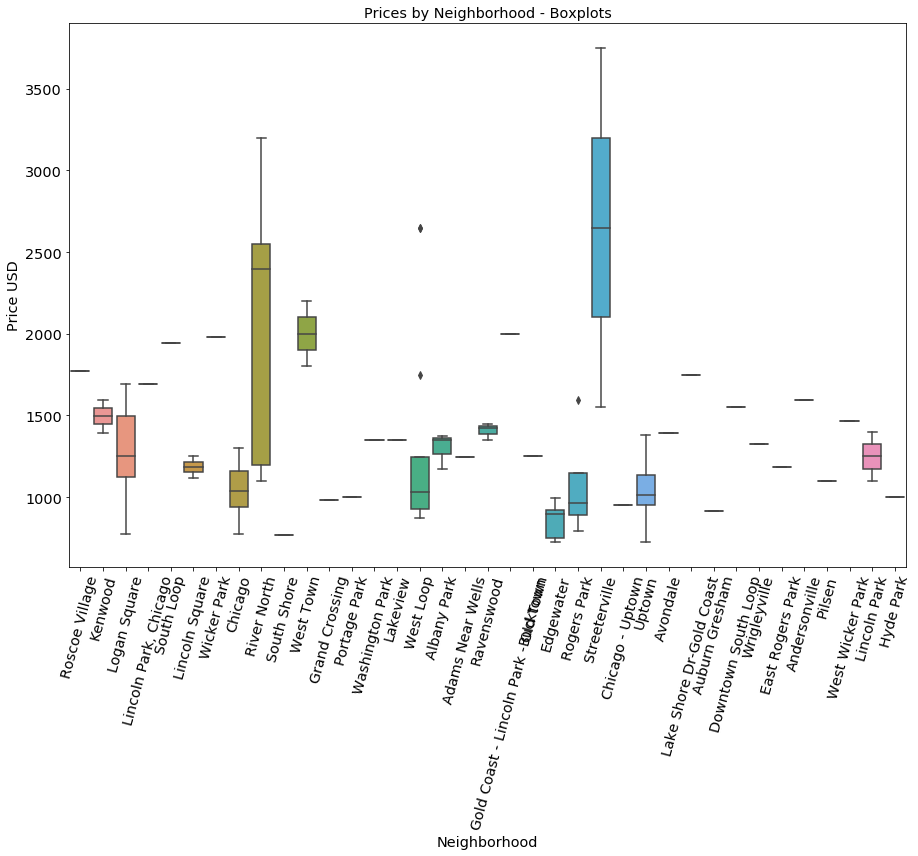

In [132]:
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='Neighborhood', y='Price', data=ch_apts)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots");

In [178]:
############################
############################
# 1 bedroom apts
###########################
###########################
###########################

# get 5 most popular neighborhoods 
chicago_apts['Neighborhood'].value_counts()[:5].index.tolist()

#break it down and do a sns barplot below with the Neighborhood hue so you can compare those different areas
#sns.stripplot(data=chicago_apts, y="Price",x="Num_Bedrooms", jitter=True)
#sns.barplot(data=chicago_apts, y= "Price", x="Num_Bedrooms",hue="Neighborhood")

['West Loop', 'Logan Square', 'Uptown', 'Chicago', 'River North']

In [150]:
#Focusing on 1 bedroom apts
#use created file
chicago_apts = pd.read_csv("Craigslist-Data.csv")

chicago_apts.info()
chicago_apts.shape
chicago_apts.columns
chicago_apts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    101 non-null    int64  
 1   Posted        101 non-null    object 
 2   Neighborhood  101 non-null    object 
 3   Post_Title    101 non-null    object 
 4   Num_Bedrooms  71 non-null     float64
 5   Sqft          33 non-null     float64
 6   URL           101 non-null    object 
 7   Price         101 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 6.4+ KB


(101, 8)

Index(['Unnamed: 0', 'Posted', 'Neighborhood', 'Post_Title', 'Num_Bedrooms',
       'Sqft', 'URL', 'Price'],
      dtype='object')

,Unnamed: 0,Posted,Neighborhood,Post_Title,Num_Bedrooms,Sqft,URL,Price
0,1,2020-12-02 12:56:00,Roscoe Village,Roscoe Village - Large 1 Bed / 1 Bath / Den,1.0,1000.0,https://chicago.craigslist.org/chc/apa/d/chica...,1775
1,2,2020-12-02 12:52:00,Kenwood,"4746 S Greenwood Ave, Unit 3E",2.0,860.0,https://chicago.craigslist.org/chc/apa/d/chica...,1595
2,3,2020-12-02 12:47:00,Logan Square,Logan Square 1 Bed Close 2 SQ! HWF|Cats Ok|1 M...,1.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1095
3,4,2020-12-02 12:46:00,Logan Square,Updated Logan Square 3 Bed w/HWF|DW|Pets Ok|De...,3.0,1034.0,https://chicago.craigslist.org/chc/apa/d/chica...,1695
4,5,2020-12-02 12:44:00,Logan Square,Logan Square 2 Bed w/HWF|Balcony|Pets Ok|One M...,2.0,940.0,https://chicago.craigslist.org/chc/apa/d/chica...,1495


In [153]:
one = chicago_apts[chicago_apts.Num_Bedrooms.eq(1.0)]
one.shape

(38, 8)

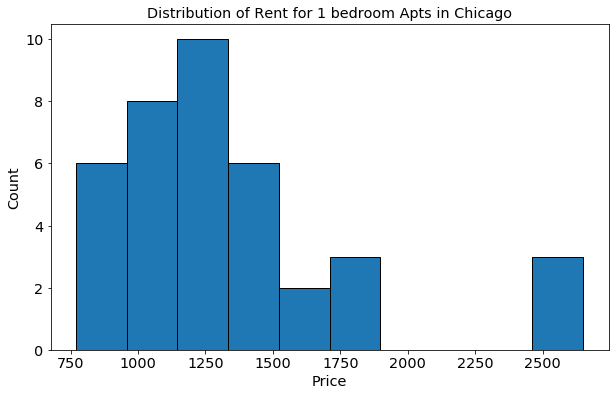

In [156]:
#start to look at the distributions
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.hist(one['Price'], edgecolor='black');
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of Rent for 1 bedroom Apts in Chicago");

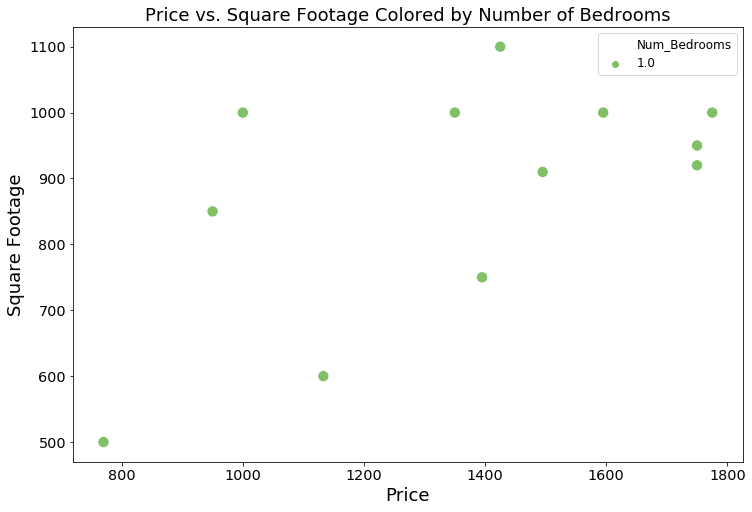

In [157]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Price', y='Sqft', hue='Num_Bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=one.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);

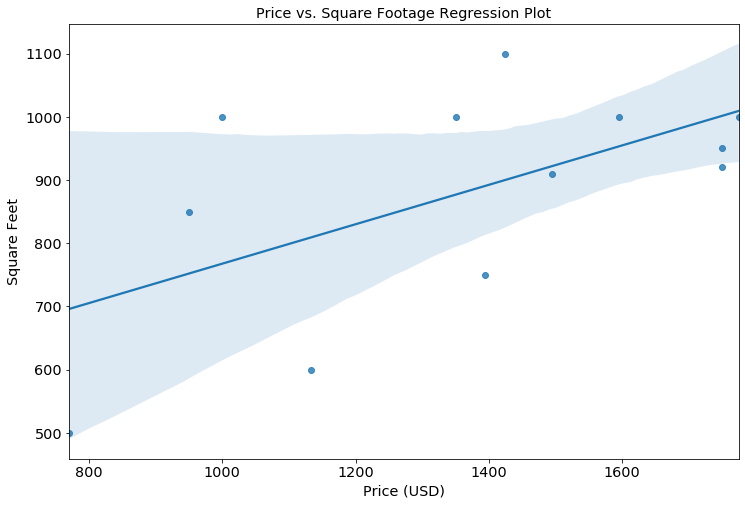

In [163]:
plt.figure(figsize=(12, 8))
sns.regplot(x='Price', y='Sqft', data=one.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price (USD)");
plt.ylabel("Square Feet");

In [164]:
#group by neighborhood
ch_apts.groupby('Neighborhood').mean()

,Num_Bedrooms,Sqft,Price
Neighborhood,,,
Adams Near Wells,1.000000,NaN,1245.000000
Albany Park,1.666667,NaN,1300.000000
Andersonville,2.000000,900.0,1596.000000
Auburn Gresham,2.000000,843.0,915.000000
Avondale,2.000000,NaN,1395.000000
Bucktown,2.000000,1000.0,1250.000000
Chicago,1.800000,950.0,1042.500000
Chicago - Uptown,1.000000,NaN,950.000000
Downtown South Loop,2.000000,850.0,1550.000000


In [166]:
#sort price to find cheapest
one.groupby('Neighborhood').mean()['Price'].sort_values()

Neighborhood
South Shore                  770.000000
Chicago                      942.000000
Chicago - Uptown             950.000000
Edgewater                    957.000000
Hyde Park                   1000.000000
Portage Park                1000.000000
Uptown                      1057.666667
Lincoln Square              1120.000000
Albany Park                 1175.000000
East Rogers Park            1185.000000
Adams Near Wells            1245.000000
Rogers Park                 1260.000000
Logan Square                1295.000000
Lakeview                    1350.000000
Kenwood                     1395.000000
Lincoln Park                1400.000000
Ravenswood                  1437.500000
West Loop                   1655.375000
Lincoln Park, Chicago       1695.000000
Lake Shore Dr-Gold Coast    1750.000000
Roscoe Village              1775.000000
River North                 2550.000000
Name: Price, dtype: float64

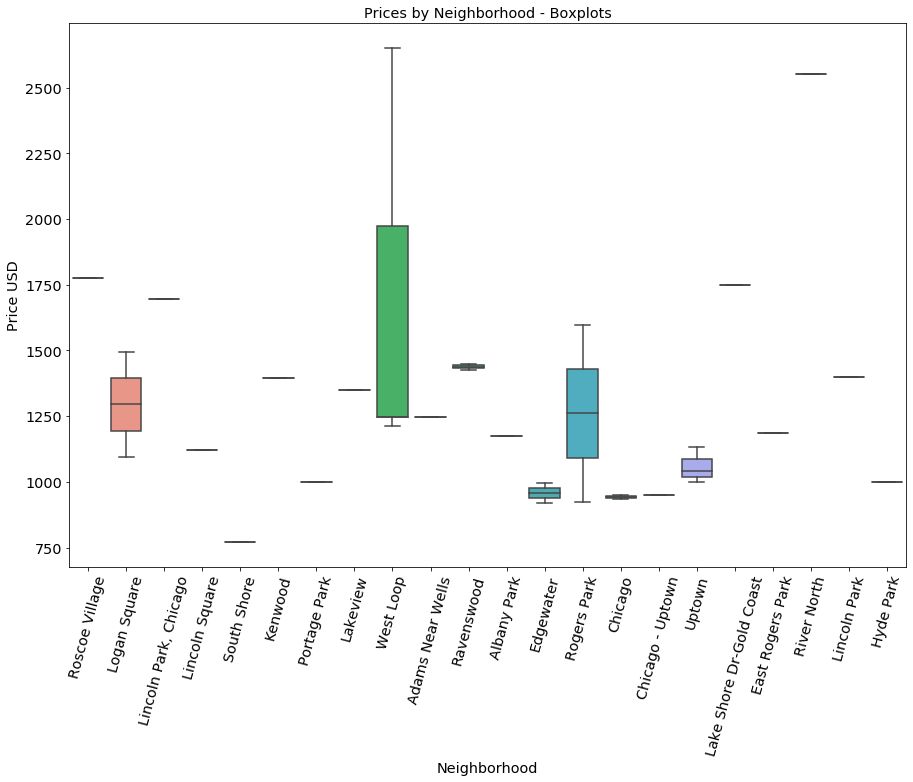

In [154]:
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='Neighborhood', y='Price', data=one)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots");